# CUISINES OPPROTUNITIES TO INVEST IN MUMBAI

Battle of Neighborhoods - A Capstone Project for Coursera IBM

### Contents:
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### INTRODUCTION

Background  

Mumbai being a financial capital of India has a large population and lot of businesses. Mumbai also being a tourist place welcomes lot of visitors both foreign and from the country. People have shown interest in experiencing the world cuisines since past years and business in international cuisines have increased apart from local cuisines. The competition is high and a restaurant needs to unique in its area to succeed.  

Problem  

Although Mumbai has lot of restaurants already, the idea of new restaurant to invest upon is lucrative. This analysis focuses on analyzing the cuisine thriving in Mumbai and exploring new opportunities to invest in a different cuisine which is more promising compared to ones nearby.  

Interest  

This report interests the investors looking for a new restaurant to invest upon. The pre-existing owners of restaurants have an extra source of information to further expand their businesses. New entrepreneurs looking at restaurants as their target business can obtain a perspective and identify opportunities from the report. 


### DATA

#### DATA SOURCES


1. **Mumbai Geo JSON**: We would be using the Geo-JSON data for Mumbai to analyze the areas and map the restaurants with the neighborhoods.  
https://github.com/datameet/Municipal_Spatial_Data/blob/master/Mumbai/BMC_Wards.geojson  
**Data which will be useful from the source : Area Names, Geo Coordinates, Area Boundaries**
  
2. **FourSquare API** : The Foursquare API would be used to obtain restaurant’s details especially the cuisine data in a nearby area.  
**Data which will be useful from the source : Restaurant ID, Cuisine ID, Cuisine Name, Location Coordinates**
  
3. **FourSquare Categories** : https://developer.foursquare.com/docs/build-with-foursquare/categories  
    We will obtain the list of Categories under "Food", filter the required ones and creat a CSV file which will be used for API calls.  
**Data which will be useful from the source : Category IDs**  
  
We will extract Location Coordinates, Name and Category from the JSON response of each API call to FourSquare. The collated data will then be put to data cleansing.


### DATA COLLECTION

In [1]:
# Importing Requird Libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip -q install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip -q install folium
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import urllib.request as urllib2
import json

import random
import os

!pip -q install shapely
from shapely.geometry import shape, Point, Polygon, MultiPoint

print('Libraries imported.')

Libraries imported.


In [2]:
# The code was removed by Watson Studio for sharing.

In [51]:
# The code was removed by Watson Studio for sharing.

##### Obtain Geo Coordinates For MUMBAI

In [5]:
address = 'Mumbai, Maharashtra'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai City are 18.9387711, 72.8353355.


#### Obtain the Data from Geo JSON File

In [18]:
# Get Geo JSON File For Mumbai

url = 'https://raw.githubusercontent.com/datameet/PincodeBoundary/master/Mumbai/boundary.geojson'

req = urllib2.Request(url)
opener = urllib2.build_opener()
f = opener.open(req)
mumbaiGEO = json.loads(f.read())

neighborhoods_data = mumbaiGEO['features']
i=0
for data in neighborhoods_data:
    newName = str(data['properties']['area_name']).strip()
    newName = str(newName).upper()
    mumbaiGEO['features'][i]['properties']['area_name'] = newName
    i=i+1

# Validate the Geo JSON Coordinates
neighborhoods_data[0]['properties']

{'objectid': 1,
 'pin_code': 400063,
 'area_name': 'GOREGAON EAST',
 'st_area(shape)': 4273102.467775,
 'st_length(shape)': 13896.409924,
 'created_user': 'posts',
 'created_date': '1409636588000',
 'last_edited_user': 'posts',
 'last_edited_date': '1409636588000',
 'name': 'GOREGAON EAST'}

#### DATA COLLECTION : Get Region Names for Mumbai
We will colate all area names from GeoJson File. Also we will calculate an approximate centre of the location (to represent the area in a map) 

In [19]:
# define the dataframe columns
column_names = ['Area', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
LLBorders = []
allLL = []
j=0
for data in neighborhoods_data:
    areaName = neighborhood_name = data['properties']['area_name'] 
    neighborhood_latlon = data['geometry']['coordinates'][0]
    
    if areaName == 'NARIMAN POINT POST OFFICE':
        neighborhood_latlon = neighborhood_latlon[0]
    
    # Get Centre Coordinates of Area
    i = 0
    Xmin = float('1000.00')
    Ymin = float('1000.00')
    Xmax = float('0.00')
    Ymax = float('0.00')
    areaLL = []
    for ll in neighborhood_latlon:
        i = i+1
        x = ll[0]
        y = ll[1]
        if x < Xmin: Xmin = x
        if y < Ymin: Ymin = y
        if x > Xmax: Xmax = x
        if y > Ymax: Ymax = y
        R = []
        R.append(areaName)
        R.append(y)
        R.append(x)
        allLL.append(R)
        areaLL.append(R)

    if i > 5000 : p = 600
    elif i > 3000 : p = 500
    elif i > 1000 : p = 250 #300
    elif i > 1000 : p = 220 #250
    elif i > 500 : p = 100 #150
    elif i > 250 : p = 100
    else: p = 50
    
    sampling = random.choices(areaLL, k = int(len(areaLL)/p) )
    LLBorders.extend(sampling)
    
    # Add Border Coordinates
    c = 0
    areaCount = 0
    
    # Calculate Centre Coordinates of Area 
    # X,Y Reversed becaouse of old format data
    Y_CEN = Xmin + ((Xmax-Xmin)/2)
    X_CEN = Ymin + ((Ymax-Ymin)/2)
    #Add Centre Coordinate
    R = []
    R.append(areaName + ' (C)')
    R.append(X_CEN)
    R.append(Y_CEN)
    LLBorders.append(R)            
    neighborhoods = neighborhoods.append({'Area': areaName, 'Latitude': X_CEN, 'Longitude': Y_CEN}, ignore_index=True)

    
LLBorders = pd.DataFrame(LLBorders,columns=column_names)
print('All Long Lat : ',LLBorders.shape)

print('Area : ', neighborhoods.shape)
neighborhoods.head()

mumbai_data = neighborhoods


All Long Lat :  (599, 3)
Area :  (89, 3)


#### Get Category List from CSV collaborated using Four Square Category List

We will load Category csv data from a manually prepared data using the FourSquare category listing.

In [20]:
########################################################### LOAD FROM CSV created using Category List of Folium

body = client_dbf72f98178848b1beeec8f1e6e9ba12.get_object(Bucket='myproject-donotdelete-pr-wh0s5lmaxejg97',Key='CAT_Mapping.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
CAT_LIST = pd.read_csv(body)
######################################3

CAT_LIST.head()

# Use The Required Categories
CAT_MAIN = CAT_LIST[CAT_LIST['Ignore']==0]
CAT_MAIN.reset_index(drop=True,inplace = True)

#Remove word Restaurant
CAT_MAIN['Main_Cat_ShortName'] = CAT_MAIN['Main_Cat_Name'].str.replace('Restaurant*','')

CAT_MAIN.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Cat_Name                    Cat_ID   L1  L2  Ignore  \
0      Afghan Restaurant  503288ae91d4c4b30a586d67  2.0 NaN       0   
1     African Restaurant  4bf58dd8d48988d1c8941735  2.0 NaN       0   
2    American Restaurant  4bf58dd8d48988d14e941735  2.0 NaN       0   
3       Asian Restaurant  4bf58dd8d48988d142941735  2.0 NaN       0   
4  Australian Restaurant  4bf58dd8d48988d169941735  2.0 NaN       0   

           Main_Cat_Name Main_Cat_ShortName  
0      Afghan Restaurant            Afghan   
1     African Restaurant           African   
2    American Restaurant          American   
3       Asian Restaurant             Asian   
4  Australian Restaurant        Australian

### DATA PREPARATION

Create Analysis Base Data

#### Obtain All Restautant Data From FourSquare

We will perform an a API call on random number of Coordinates for each Area (collection generated above) with a radious of 2.5km thereby covering maximum of the areas of Mumbai.

Setup Credentials for FourSquare

In [21]:
# The code was removed by Watson Studio for sharing.

In [22]:
# Colate All Required Categories 

VERSION = '20180604'
LIMIT = 1000
radius = 2500 #1000m

LAT = 0
LNG = 0 
# Head Category :  Food 4d4b7105d754a06374d81259

# Get List of Filtered Categories for API call
#categoryId = ','.join(listCategories)
categoryId = ','.join(CAT_MAIN['Cat_ID'].tolist())
categoryId

'503288ae91d4c4b30a586d67,4bf58dd8d48988d1c8941735,4bf58dd8d48988d14e941735,4bf58dd8d48988d142941735,4bf58dd8d48988d169941735,52e81612bcbc57f1066b7a01,5e179ee74ae8e90006e9a746,52e81612bcbc57f1066b7a02,4bf58dd8d48988d144941735,5293a7d53cf9994f4e043a45,52f2ae52bcbc57f1066b8b81,4bf58dd8d48988d109941735,52e81612bcbc57f1066b7a05,4bf58dd8d48988d10b941735,4bf58dd8d48988d10c941735,4bf58dd8d48988d10d941735,4bf58dd8d48988d10e941735,52e81612bcbc57f1066b79fe,52e81612bcbc57f1066b79fa,4bf58dd8d48988d110941735,52e81612bcbc57f1066b79fd,4bf58dd8d48988d1be941735,4bf58dd8d48988d1c0941735,4bf58dd8d48988d1c1941735,4bf58dd8d48988d115941735,52e81612bcbc57f1066b79f9,52e81612bcbc57f1066b79f8,52e81612bcbc57f1066b7a04,4def73e84765ae376e57713a,5293a7563cf9994f4e043a44,4bf58dd8d48988d1c6941735,5744ccdde4b0c0459246b4a3,4bf58dd8d48988d150941735,5413605de4b0ae91d18581a9,4bf58dd8d48988d158941735,4f04af1f2fb6e1c99f3db0bb,52e928d0bcbc57f1066b7e96'

### Convert Venues into Required Data Frame

In [24]:
# GET ALL VENUES FOR MUMBAI

# Temp List
ds = []
for i,r in LLBorders.iterrows():
    try:
        if i > 5:
            break
        # Get Data for A Location
        LAT = LLBorders.loc[i,'Latitude']
        LNG = LLBorders.loc[i,'Longitude']

        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LAT, LNG, VERSION, categoryId, radius, LIMIT)
        results = requests.get(url).json()

        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # tranform venues into a dataframe
        dfVenues = json_normalize(venues)
        #print('Shape : ',dfVenues.shape)
        dfVenues.head()

        for index,row in dfVenues.iterrows():   
            #New Temp Row
            R = []

            R.append(row["id"]) #ID
            R.append(row["name"]) # Name
            R.append(row["location.address"]) #Address
            R.append(row["location.lat"]) #Lat
            R.append(row["location.lng"]) #Lon

            try:
                categories_list = row['categories']
            except:
                categories_list = row['venue.categories']

            if len(categories_list) == 0:
                R.append('NaN')
                R.append('NaN')
                R.append('NaN')
            else:
                R.append(categories_list[0]['id']) # Cat ID
                R.append(categories_list[0]['pluralName']) # Cat Name
                R.append(categories_list[0]['shortName']) # Cat Short Name

            ds.append(R)  
             
        #if i == 5 :
        #    break;
    except Exception as inst:
        print('Error at ',i, )   
        print(inst)
    finally:
        counter = i
        #print('ROWS :', dfVenues.shape ,' || Curent Total Rows : ', len(ds) , '|| ',i,' of ', LLBorders.shape)
        
print('Restaurant Data Fetched from Four Square')

Restaurant Data Fetched from Four Square


In [201]:
CUS_columns = ['ID','Name','Address','Latitude','Longitude','Cat_ID','Cat_Name','Cat_ShortName']
dfCUS = pd.DataFrame(ds,columns = CUS_columns)

print('Shape : ',dfCUS.shape)
dfCUS.head()

Shape :  (27759, 8)


ID                        Name  \
0  507e2d35e4b0f283dd6b0e56                      vinoda   
1  4d4ec3db23a76dcb7c2d63dc          Pratap's The Dhaba   
2  501a971ee4b00bf33ff1ab87            Quesso Risorante   
3  4d8cd971ca75b60c4368dba8  Sernyaa Tibetan Restaurant   
4  5a297f588c812a5e2e03448b              The Leaf Twist   

                                      Address   Latitude  Longitude  \
0                                         NaN  19.165090  72.847079   
1                  Link Plaza, Mhada Complex,  19.148876  72.832097   
2  93-96 Link Plaza, Above Shreejee, Oshiwawa  19.148772  72.831381   
3    Near Spectrum Towers, Opp Guru Kripa bar  19.179506  72.837099   
4                                         NaN  19.180960  72.836340   

                     Cat_ID              Cat_Name Cat_ShortName  
0  4bf58dd8d48988d145941735   Chinese Restaurants       Chinese  
1  4bf58dd8d48988d10f941735    Indian Restaurants        Indian  
2  4bf58dd8d48988d110941735   Italian Restaurants       Italian  
3  4bf58dd8d48988d108941735  Dumpling Restaurants     Dumplings  
4  4bf58dd8d48988d142941735     Asian Restaurants         Asian

### DATA PREPARATION : Create Analysis Base Data

1. Remove Duplicate Content  
2. Remove Spaces in Content  
3. Remove NaN values
4. Remove restaurants not belonging to required criteria
5. Remove Indian and Chinese and Pizza restaurants
6. Rename Sub Cateogry to Primary Cateog0ry
7. Fill Missing Category data
8. Join Category to Primary Category Data

In [54]:
CAT_MAP = dfCUS
print('Shape Before Removing Duplicates : ',CAT_MAP.shape)
# Remove Duplicates
CAT_MAP = CAT_MAP.drop_duplicates()

print('Unique IDs : ',len(CAT_MAP['ID'].unique()))

CAT_MAP = CAT_MAP.merge(CAT_MAIN, on = 'Cat_ID', how = 'left')
CAT_MAP.drop(['Cat_Name_x', 'Cat_Name_y','L1','L2','Ignore'], axis=1, inplace=True)

print('Shape After Removing Duplicates : ',CAT_MAP.shape)
CAT_MAP.head()

# Trim The Names
CAT_MAP['Cat_ShortName'] = CAT_MAP['Cat_ShortName'].str.strip()
CAT_MAP['Main_Cat_ShortName'] = CAT_MAP['Main_Cat_ShortName'].str.strip()


# Replace 'Main_Cat_ShortName' with 'Cat_ShortName' where 'Main_Cat_ShortName' == 'NaN'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName.isnull())] = CAT_MAP['Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName.isnull())]


# Update Main_Cat_ShortName'

CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Dim Sum')] = 'Chinese'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'New American')] = 'American'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Noodles')] = 'Chinese'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Tapas')] = 'Spanish'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Modern European')] = 'European'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Eastern European')] = 'European'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Burritos')] = 'Mexican'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Shawarma Place')] = 'Middle Eastern'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Falafel')] = 'Middle Eastern'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Tacos')] = 'Mexican'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Tex-Mex')] = 'Mexican'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Burgers')] = 'American'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'South American')] = 'American'
CAT_MAP['Main_Cat_ShortName'].loc[(CAT_MAP.Main_Cat_ShortName == 'Japanese Curry')] = 'Japanese'

# Remove Rows with Below unwanted list:
#'Fast Food','Indian','Hotel','Chinese','Bar','Wine Bar','Bakery','Lounge','Seafood','Breakfast','Desserts','Diner','Vegetarian / Vegan',
#'Sandwiches','Food Court','Hotel Bar','Indian Chinese','Steakhouse','Fried Chicken','Arcade','Buffet',
#'Dumplings','Bistro','Deli / Bodega','Coffee Shop','Wine Bar','Szechuan'

CAT_MAP = CAT_MAP[(CAT_MAP.Cat_ShortName !='Chinese') & (CAT_MAP.Cat_ShortName !='Asian')
    & (CAT_MAP.Cat_ShortName !='Fast Food') & (CAT_MAP.Cat_ShortName !='Indian')  
    & (CAT_MAP.Cat_ShortName !='Hotel') & (CAT_MAP.Cat_ShortName !='Bar') & (CAT_MAP.Cat_ShortName !='Pizza') 
    & (CAT_MAP.Cat_ShortName !='Wine Bar') & (CAT_MAP.Cat_ShortName !='Bakery')  & (CAT_MAP.Cat_ShortName !='Lounge') & (CAT_MAP.Cat_ShortName !='Seafood') 
    & (CAT_MAP.Cat_ShortName !='Breakfast') & (CAT_MAP.Cat_ShortName !='Desserts')  & (CAT_MAP.Cat_ShortName !='Diner') & (CAT_MAP.Cat_ShortName !='Vegetarian / Vegan') 
    & (CAT_MAP.Cat_ShortName !='Sandwiches') & (CAT_MAP.Cat_ShortName !='Hotel Bar')  & (CAT_MAP.Cat_ShortName !='Indian Chinese') & (CAT_MAP.Cat_ShortName !='Steakhouse') 
    & (CAT_MAP.Cat_ShortName !='Fried Chicken') & (CAT_MAP.Cat_ShortName !='Arcade')  & (CAT_MAP.Cat_ShortName !='Buffet') & (CAT_MAP.Cat_ShortName !='Dumplings') 
    & (CAT_MAP.Cat_ShortName !='Bistro') & (CAT_MAP.Cat_ShortName !='Deli / Bodega')  & (CAT_MAP.Cat_ShortName !='Coffee Shop') & (CAT_MAP.Cat_ShortName !='Wine Bar') 
    & (CAT_MAP.Cat_ShortName !='Szechuan') & (CAT_MAP.Cat_ShortName !='Pub') & (CAT_MAP.Cat_ShortName !='Café') & (CAT_MAP.Cat_ShortName !='Molecular Gastronomy')
    & (CAT_MAP.Cat_ShortName !='Halal')]

CAT_MAP = CAT_MAP[ (CAT_MAP.Main_Cat_ShortName !='Chinese') & (CAT_MAP.Main_Cat_ShortName !='Asian')
    & (CAT_MAP.Main_Cat_ShortName !='Fast Food') & (CAT_MAP.Main_Cat_ShortName !='Indian')  
    & (CAT_MAP.Main_Cat_ShortName !='Hotel') & (CAT_MAP.Main_Cat_ShortName !='Bar') & (CAT_MAP.Main_Cat_ShortName !='Pizza') 
    & (CAT_MAP.Main_Cat_ShortName !='Wine Bar') & (CAT_MAP.Main_Cat_ShortName !='Bakery')  & (CAT_MAP.Main_Cat_ShortName !='Lounge') & (CAT_MAP.Main_Cat_ShortName !='Seafood') 
    & (CAT_MAP.Main_Cat_ShortName !='Breakfast') & (CAT_MAP.Main_Cat_ShortName !='Desserts')  & (CAT_MAP.Main_Cat_ShortName !='Diner') & (CAT_MAP.Main_Cat_ShortName !='Vegetarian / Vegan') 
    & (CAT_MAP.Main_Cat_ShortName !='Sandwiches') & (CAT_MAP.Main_Cat_ShortName !='Hotel Bar')  & (CAT_MAP.Main_Cat_ShortName !='Indian Chinese') & (CAT_MAP.Main_Cat_ShortName !='Steakhouse') 
    & (CAT_MAP.Main_Cat_ShortName !='Fried Chicken') & (CAT_MAP.Main_Cat_ShortName !='Arcade')  & (CAT_MAP.Main_Cat_ShortName !='Buffet') & (CAT_MAP.Main_Cat_ShortName !='Dumplings') 
    & (CAT_MAP.Main_Cat_ShortName !='Bistro') & (CAT_MAP.Main_Cat_ShortName !='Deli / Bodega')  & (CAT_MAP.Main_Cat_ShortName !='Coffee Shop') & (CAT_MAP.Main_Cat_ShortName !='Wine Bar') 
    & (CAT_MAP.Main_Cat_ShortName !='Szechuan') & (CAT_MAP.Main_Cat_ShortName !='Pub') & (CAT_MAP.Main_Cat_ShortName !='Café') & (CAT_MAP.Main_Cat_ShortName !='Molecular Gastronomy')
    & (CAT_MAP.Main_Cat_ShortName !='Halal') & (CAT_MAP.Main_Cat_ShortName !='Food Court') & (CAT_MAP.Main_Cat_ShortName !='Northeast Indian')]


# Drop Main Category Long Name
CAT_MAP.drop(['Main_Cat_Name'],axis=1)

# Add Area Column
CAT_MAP['Area'] = 'NA'
CAT_MAP.reset_index(drop=True,inplace = True)
CAT_MAP.head()

#CAT_MAP['Cat_ShortName'].value_counts()

Shape Before Removing Duplicates :  (27759, 8)
Unique IDs :  1384
Shape After Removing Duplicates :  (1384, 9)


ID                         Name  \
0  501a971ee4b00bf33ff1ab87             Quesso Risorante   
1  5557752f498eccd4a1cb736f                    taco bell   
2  4c78865a2d3ba143027c8bd0                        Prego   
3  50b0feabe4b03c6b1e51e412  anna idli sambhar medu wada   
4  551d65f9498e0bad32d2349e                      TUK TUK   

                                           Address   Latitude  Longitude  \
0       93-96 Link Plaza, Above Shreejee, Oshiwawa  19.148772  72.831381   
1                                      Oberoi Mall  19.176264  72.862382   
2  International Business Park, Oberoi Garden City  19.172650  72.860339   
3                                              NaN  19.182206  72.830610   
4                                              NaN  19.144918  72.831270   

                     Cat_ID Cat_ShortName       Main_Cat_Name  \
0  4bf58dd8d48988d110941735       Italian  Italian Restaurant   
1  4bf58dd8d48988d1c1941735       Mexican  Mexican Restaurant   
2  4bf58dd8d48988d110941735       Italian  Italian Restaurant   
3  4bf58dd8d48988d10e941735         Greek    Greek Restaurant   
4  4bf58dd8d48988d149941735          Thai                 NaN   

  Main_Cat_ShortName Area  
0            Italian   NA  
1            Mexican   NA  
2            Italian   NA  
3              Greek   NA  
4               Thai   NA

In [55]:
print(CAT_MAP['Main_Cat_ShortName'].unique())

['Italian' 'Mexican' 'Greek' 'Thai' 'Tibetan' 'Burmese' 'Afghan'
 'Cantonese' 'English' 'Persian' 'American' 'Filipino' 'Mediterranean'
 'Arepas' 'Argentinian' 'Middle Eastern' 'Sri Lankan' 'French' 'Japanese'
 'Turkish' 'Portuguese' 'German' 'Sushi' 'African' 'Australian' 'Souvlaki'
 'Belgian' 'European' 'Cuban' 'Lebanese' 'Spanish' 'Moroccan' 'Vietnamese'
 'Brazilian' 'Scandinavian' 'Korean' 'Caribbean' 'Indonesian' 'Caucasian'
 'Latin American' 'Swiss' 'Peruvian' 'Shanghai']


#### Create Geo JSON Data with Restaurant Counts

We will use Shapely Library to create a polygon and map the restaurant to the most appropiate Area. Further, we gather the count of each restaurnat in an Area.

In [56]:
# Add Count of Restaurants in Mumbai_MAP
MUM_DATA = mumbai_data
MUM_DATA['Area'] = MUM_DATA['Area'].str.strip()
MUM_DATA['Area'] = MUM_DATA['Area'].str.upper()
MUM_DATA.reset_index(drop=True,inplace = True)
MUM_DATA['Total'] = 0

for index,row in CAT_MAP.iterrows():
        
    if ( index % 20 ) == 0 :
        print(str(int(index / len(CAT_MAP.index) * 100))+'% ', end='')

    #Get Area from Coordinates 
    LAT = row['Latitude']
    LNG = row['Longitude']

    point = Point(LNG, LAT)
    # check each polygon to see if it contains the point
    for feature in mumbaiGEO['features']:
        polygon = shape(feature['geometry'])
        if point.within(polygon):
            region = str(feature['properties']['area_name']).strip()
            region = str(region).upper()
            #print('Found containing polygon:', feature['properties']['area_name'])
    
    # Add Count to Mumbai Area       
    MUM_DATA['Total'].loc[(MUM_DATA.Area == region)] = MUM_DATA['Total'].loc[(MUM_DATA.Area == region)] + 1
    
    #Update Area Location for Restaurants
    CAT_MAP.loc[index,'Area'] = region
    
MUM_DATA.head()

0% 3% 6% 9% 13% 16% 19% 23% 26% 29% 33% 36% 39% 42% 46% 49% 52% 56% 59% 62% 66% 69% 72% 75% 79% 82% 85% 89% 92% 95% 99% 

Area   Latitude  Longitude  Total
0             GOREGAON EAST  19.160375  72.861837     11
1  MARINE LINES POST OFFICE  18.934761  72.826237     14
2              TAGORE NAGAR  19.117426  72.932465      4
3              JACOB CIRCLE  18.982742  72.827008      1
4         MUMBAI CENTRAL HO  18.970014  72.827538      6

In [57]:
# Validate if any Null Category Names
CAT_MAP['Main_Cat_ShortName'].isnull().values.any()

False

In [58]:
# one hot encoding
CAT_MAP['Main_Cat_ShortName'] = CAT_MAP['Main_Cat_ShortName'].str.strip()
CAT_onehot = pd.get_dummies(CAT_MAP[['Main_Cat_ShortName']], prefix="", prefix_sep="")
print('Total Cuisines Restaurants : ',len(CAT_onehot.index))
CAT_onehot.shape
CAT_MAP.head()

Total Cuisines Restaurants :  606


ID                         Name  \
0  501a971ee4b00bf33ff1ab87             Quesso Risorante   
1  5557752f498eccd4a1cb736f                    taco bell   
2  4c78865a2d3ba143027c8bd0                        Prego   
3  50b0feabe4b03c6b1e51e412  anna idli sambhar medu wada   
4  551d65f9498e0bad32d2349e                      TUK TUK   

                                           Address   Latitude  Longitude  \
0       93-96 Link Plaza, Above Shreejee, Oshiwawa  19.148772  72.831381   
1                                      Oberoi Mall  19.176264  72.862382   
2  International Business Park, Oberoi Garden City  19.172650  72.860339   
3                                              NaN  19.182206  72.830610   
4                                              NaN  19.144918  72.831270   

                     Cat_ID Cat_ShortName       Main_Cat_Name  \
0  4bf58dd8d48988d110941735       Italian  Italian Restaurant   
1  4bf58dd8d48988d1c1941735       Mexican  Mexican Restaurant   
2  4bf58dd8d48988d110941735       Italian  Italian Restaurant   
3  4bf58dd8d48988d10e941735         Greek    Greek Restaurant   
4  4bf58dd8d48988d149941735          Thai                 NaN   

  Main_Cat_ShortName             Area  
0            Italian  JOGESHWARI WEST  
1            Mexican       MALAD EAST  
2            Italian    GOREGAON EAST  
3              Greek       MALAD WEST  
4               Thai  JOGESHWARI WEST

#### Area Count Data Frame
We create a join of Area and Cuisine dataframes. This will help visualize data against each Area, each Cuisine and respective Count

In [59]:
# Append Cuisines to Area with Count
AREA_TOT = MUM_DATA
AREA_TOT.reset_index(drop=True,inplace = True)
col = []
col.extend(MUM_DATA.columns)
for c in CAT_onehot.columns:
    col.append(c.strip())
    
AREA_TOT = pd.DataFrame(MUM_DATA,columns = col)
AREA_TOT.fillna(0, inplace=True)

for index,row in CAT_MAP.iterrows():
    area = CAT_MAP.loc[index,'Area']
    cat = CAT_MAP.loc[index,'Main_Cat_ShortName'].strip()
    i = AREA_TOT.loc[AREA_TOT['Area'] == area].index
    AREA_TOT.loc[i,cat] = AREA_TOT.loc[i,cat] + 1

AREA_TOT = AREA_TOT[AREA_TOT.Total != 0]

AREA_TOT.head()

Area   Latitude  Longitude  Total  Afghan  African  \
0             GOREGAON EAST  19.160375  72.861837     11     1.0      0.0   
1  MARINE LINES POST OFFICE  18.934761  72.826237     14     0.0      0.0   
2              TAGORE NAGAR  19.117426  72.932465      4     0.0      0.0   
3              JACOB CIRCLE  18.982742  72.827008      1     0.0      0.0   
4         MUMBAI CENTRAL HO  18.970014  72.827538      6     2.0      0.0   

   American  Arepas  Argentinian  Australian  Belgian  Brazilian  Burmese  \
0       1.0     0.0          0.0         0.0      1.0        0.0      0.0   
1       2.0     0.0          0.0         0.0      0.0        0.0      0.0   
2       0.0     0.0          0.0         1.0      0.0        0.0      0.0   
3       0.0     0.0          0.0         0.0      0.0        0.0      0.0   
4       0.0     0.0          0.0         0.0      0.0        0.0      0.0   

   Cantonese  Caribbean  Caucasian  Cuban  English  European  Filipino  \
0        0.0        0.0        0.0    0.0      1.0       0.0       0.0   
1        0.0        0.0        0.0    0.0      1.0       0.0       0.0   
2        0.0        0.0        0.0    1.0      0.0       0.0       0.0   
3        0.0        0.0        0.0    0.0      0.0       1.0       0.0   
4        0.0        0.0        0.0    0.0      0.0       0.0       0.0   

   French  German  Greek  Indonesian  Italian  Japanese  Korean  \
0     0.0     0.0    0.0         0.0      2.0       0.0     0.0   
1     3.0     0.0    0.0         0.0      4.0       0.0     0.0   
2     1.0     0.0    0.0         0.0      0.0       0.0     0.0   
3     0.0     0.0    0.0         0.0      0.0       0.0     0.0   
4     0.0     0.0    0.0         0.0      0.0       0.0     0.0   

   Latin American  Lebanese  Mediterranean  Mexican  Middle Eastern  Moroccan  \
0             0.0       0.0            0.0      2.0             3.0       0.0   
1             0.0       0.0            1.0      1.0             0.0       0.0   
2             0.0       0.0            0.0      0.0             0.0       0.0   
3             0.0       0.0            0.0      0.0             0.0       0.0   
4             0.0       0.0            0.0      0.0             3.0       0.0   

   Persian  Peruvian  Portuguese  Scandinavian  Shanghai  Souvlaki  Spanish  \
0      0.0       0.0         0.0           0.0       0.0       0.0      0.0   
1      0.0       0.0         0.0           0.0       0.0       0.0      0.0   
2      0.0       0.0         0.0           0.0       0.0       1.0      0.0   
3      0.0       0.0         0.0           0.0       0.0       0.0      0.0   
4      0.0       0.0         0.0           0.0       0.0       0.0      0.0   

   Sri Lankan  Sushi  Swiss  Thai  Tibetan  Turkish  Vietnamese  
0         0.0    0.0    0.0   0.0      0.0      0.0         0.0  
1         1.0    0.0    0.0   1.0      0.0      0.0         0.0  
2         0.0    0.0    0.0   0.0      0.0      0.0         0.0  
3         0.0    0.0    0.0   0.0      0.0      0.0         0.0  
4         0.0    0.0    0.0   0.0      0.0      0.0         1.0

In [60]:
print(CAT_MAP['Area'].unique())

['JOGESHWARI WEST' 'MALAD EAST' 'GOREGAON EAST' 'MALAD WEST'
 'MOTILALNAGAR' 'A M COLONY' 'JOGESHWARI EAST' 'MARINE LINES POST OFFICE'
 'MUMBAI GPO' 'NARIMAN POINT POST OFFICE' 'COLABA POST OFFICE' 'KALBADEVI'
 'GRANT ROAD' 'MANDVI' 'TAGORE NAGAR' 'IIT POWAI' 'VIKHROLI'
 'BHANDUP EAST' 'BHANDUP WEST' 'GHATKOPAR WEST' 'SAKINAKA POST OFFICE'
 'DELISLE ROAD' 'CUMBALLA HILL' 'TULSIWADI' 'WORLI MDG'
 'MUMBAI CENTRAL HO' 'JACOB CIRCLE' 'PRABHADEVI' 'GIRGAON'
 'CHINCHBUNDER HO' 'JUHU PO' 'SAHAR PO.' 'VILE PARLE EAST S.O'
 'J.B.NAGAR S.O.' 'ANDHERI R.S.PO' 'ANDHRI EAST P.O.' 'CHAKALA MIDC S.O.'
 'SANTACRUZ EAST P.O.' 'SANTACRUZ WEST S.O.' 'KHAR DELIVERY S.O.' 'SION'
 'BANDRA WEST S.O.' 'MATUNGA' 'VIDYANAGARI P.O' 'BANDRA EAST P.O.'
 'MAHIM HEAD POST OFFOCE' 'WADALA PO' 'BHAWANI SHANKAR PO'
 'WORLI COLONY PO' 'SEWRI' 'DADAR HO' 'PAREL MDG' 'BHANDUP COMPLEX PO'
 'MULUND WEST' 'MULUND EAST' 'CHEMBUR HO' 'TILAK NAGAR' 'RAJAWADI PO'
 'KURLA POST OFFICE' 'AMTOP HILL PO' 'KANDIVALI WEST' 'KANDIVALI E

### METHODOLOGY

This project we will perform analysis on various types of restaurants and the areas which are more into cusine culture. We will be exploring all the areas of Mumbai and focus on restaurants with International cuisines. 

We obtained information of all the restaurants in the Mumbai vicinity along with their Geo Coordinates obtained from FourSquare. We have considered a range of 2.5Km and explored random points on each area borders for restaurants, thereby covering the entire Mumbai area. The redundant information has been removed and the contents streamlined. We have ignored the Indian and Chinese cuisines. The Indian cuisine is ignored as we want to focus on International cuisines. The Chinese cuisine is ignored as the same is equally dominant in almost all areas across Mumbai. The categories of restaurants has been filtered using the information on FourSquare category listing. 

Next, We will calculate the number of restaurants in each area. We will map them by cross referencing the restaurant location coordinates with the GeoJson polygon areas. Furhter, we will create data of the types of restaurants and their respective counts across Mumbai.  

Next, we will plot the restaurnats on Map to visualize the areas and have a better prspective of their locations. We will also plot a Heat Map to visualize the flourishing areas. We will plot graphs to find what are the most areas which are more into variety of cusines and what cusines are currently available. 


### ANALYSIS 

#### All Restaurants in Different Areas

We now create a map to locate all restaurants in the areas to visualize the sparcity.

In [61]:
# Show restaurants on Map

# create a plain Mumbai Map
# let Folium determine the scale.
mumbai_map2 = folium.Map(location=[latitude,longitude], zoom_start=12)

mumbai_map2.choropleth (
    geo_data = mumbaiGEO,
    data = AREA_TOT,
    columns=['Area', 'Total'],
    key_on = 'feature.properties.area_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurant Distribution in Mumbai',
    reset=True
)

# add markers to map for Area Locations
for lat, lng, label in zip(MUM_DATA['Latitude'], MUM_DATA['Longitude'], MUM_DATA['Area']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mumbai_map2)  

# add markers to map for Restaurants
for lat, lng, label in zip(CAT_MAP['Latitude'], CAT_MAP['Longitude'], CAT_MAP['Main_Cat_ShortName']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 1,
        popup=label,
        color='maroon',
        fill=True,
        fill_color='#8B0000',
        fill_opacity=0.7,
        parse_html=False).add_to(mumbai_map2)  
    
#display map
mumbai_map2


/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Heat Map to Representing the ditribution of restaurants In Mumbai


In [62]:
from glob import glob
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap

#Lat, Long, Count
#data = MUM_DATA.iloc[:,1:4]
data = data = CAT_MAP.iloc[:,3:5]

heat_map = folium.Map([latitude, longitude], tiles='stamentoner', zoom_start=10)
HeatMap(data).add_to(folium.FeatureGroup(name='Heat Map').add_to(heat_map))
folium.LayerControl().add_to(heat_map)

# add markers to map
for lat, lng, label in zip(MUM_DATA['Latitude'], MUM_DATA['Longitude'], MUM_DATA['Area']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(heat_map) 
    
heat_map

### #Types of Cuisines across Mumbai with counts

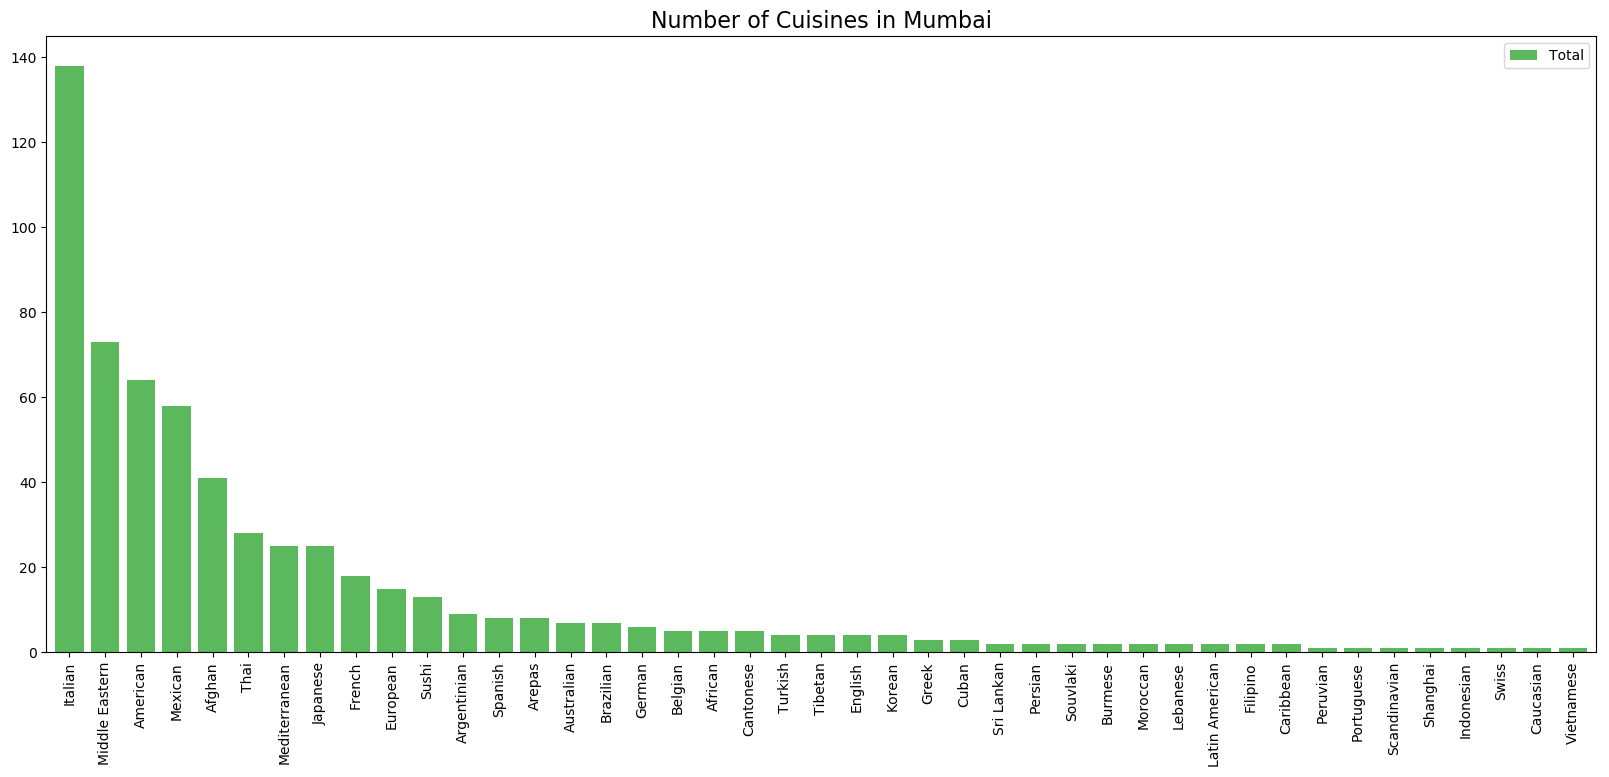

In [63]:
# Bar Chart to Reperesent Cusine Counts
# Total Cusines in Area
CUS_COUNT = CAT_MAP.groupby('Main_Cat_ShortName').count()
CUS_COUNT = pd.DataFrame(CUS_COUNT['Area'])
CUS_COUNT['T'] = CUS_COUNT.index
CUS_COUNT.columns = ['Total','Cuisine']
CUS_COUNT = CUS_COUNT[(CUS_COUNT.Cuisine != 'Chinese')]
CUS_COUNT.reset_index(drop=True,inplace = True)
CUS_COUNT.head()
CUS_COUNT.sort_values(by= 'Total', ascending = False,inplace = True)

fig = plt.figure()
ax0 =  fig.add_subplot(111)
ax0.set_title('Number of Cuisines in Mumbai', fontsize = 16)

CUS_COUNT.plot(kind='bar', figsize=(20,8), width=0.8, color = ['#5cb85c','#5bc0de','#d9534f'], ax = ax0 )

plt.xticks(np.arange(len(CUS_COUNT.index)),tuple(list(CUS_COUNT['Cuisine'])),rotation=90,fontsize=10)

x = CUS_COUNT['Cuisine']
y = CUS_COUNT['Total']
labels = x
#plt.bar(x,y, width = 0.5)
#plt.xticks(x, labels, rotation='vertical')

#width_in_inches = 10
#height_in_inches = 4
#dots_per_inch = 70
#plt.figure(    figsize=(width_in_inches,height_in_inches),dpi=dots_per_inch)

plt.show()

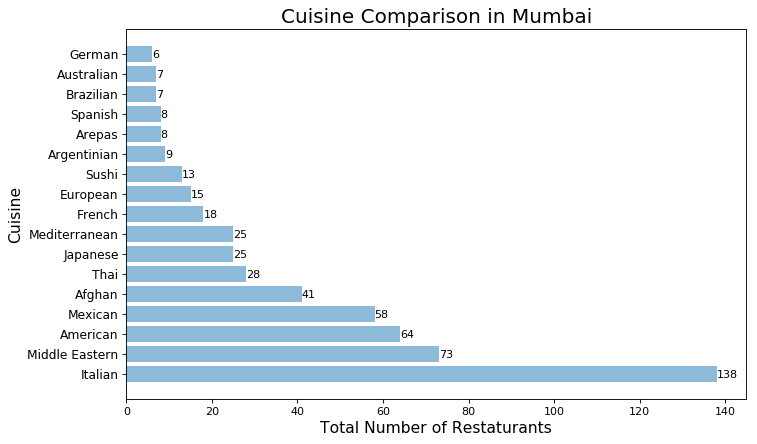

In [65]:
# Bar Chart to Reperesent Top Cusine Counts
# Total Cusines in Area
CUS_COUNT = CAT_MAP.groupby('Main_Cat_ShortName').count()
CUS_COUNT = pd.DataFrame(CUS_COUNT['Area'])
CUS_COUNT['T'] = CUS_COUNT.index
CUS_COUNT.columns = ['Total','Cuisine']
CUS_COUNT = CUS_COUNT[(CUS_COUNT.Cuisine != 'Chinese')]
CUS_COUNT = CUS_COUNT[(CUS_COUNT.Total > 5)]
CUS_COUNT.reset_index(drop=True,inplace = True)
CUS_COUNT.head()
CUS_COUNT.sort_values(by= 'Total', ascending = False,inplace = True)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(CUS_COUNT['Cuisine']))
totValue = CUS_COUNT['Total']

plt.barh(y_pos, totValue, align='center', alpha=0.5)
plt.yticks(y_pos, CUS_COUNT['Cuisine'], fontsize=11)

plt.xlabel('Total Number of Restaturants',fontsize=14)
plt.ylabel('Cuisine',fontsize=14)
plt.title('Cuisine Comparison in Mumbai',fontsize=18)

j = 0
for i in totValue:
    plt.text( i  ,j - 0.2, i ,fontsize = 10)
    j = j+1
    
plt.show()

### Top  Areas with Most Restaurants in Mumbai

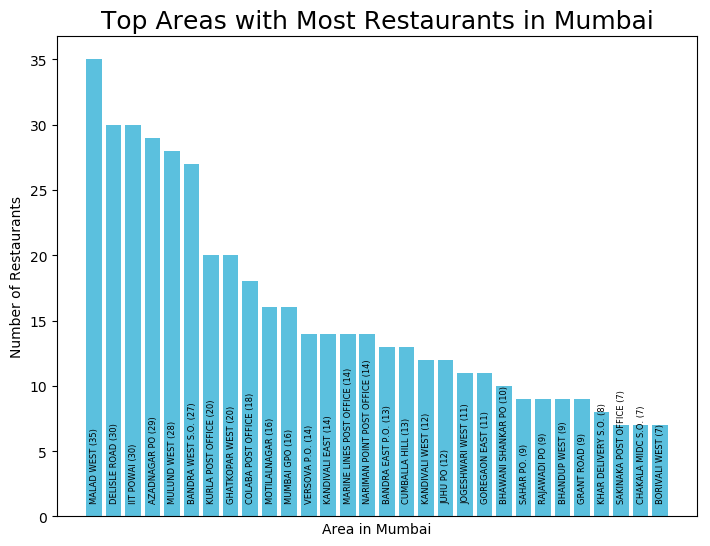

In [66]:
MUM_CUS_COUNT = AREA_TOT
MUM_CUS_COUNT['Total'] = MUM_CUS_COUNT['Total']
MUM_CUS_COUNT.sort_values(by= 'Total', ascending = False,inplace = True)
MUM_CUS_COUNT.reset_index(drop=True,inplace = True)
MUM_CUS_COUNT = MUM_CUS_COUNT.head(30)
MUM_CUS_COUNT

fig = plt.figure(facecolor = 'w')
ax = fig.add_axes([0,0,1,1])
ax.bar(MUM_CUS_COUNT['Area'],MUM_CUS_COUNT['Total'],color = '#5bc0de')
ax.set_xticks([])

for index,row in MUM_CUS_COUNT.iterrows():
     ax.text(index - 0.2, 1 , row['Area']+' ('+ str(row['Total']) + ')', fontsize = 6, rotation= 90, color = 'black',verticalalignment='bottom')

ax.set_xlabel('Area in Mumbai')
ax.set_ylabel('Number of Restaurants')

plt.title('Top Areas with Most Restaurants in Mumbai',fontsize=18)

plt.show()

### Richness Of Cuisnes in Mumbai 

(Creat an Index which calculates an Index value using Number of Restatuans of Each Cuisine Type)



#Top 15 Cusines


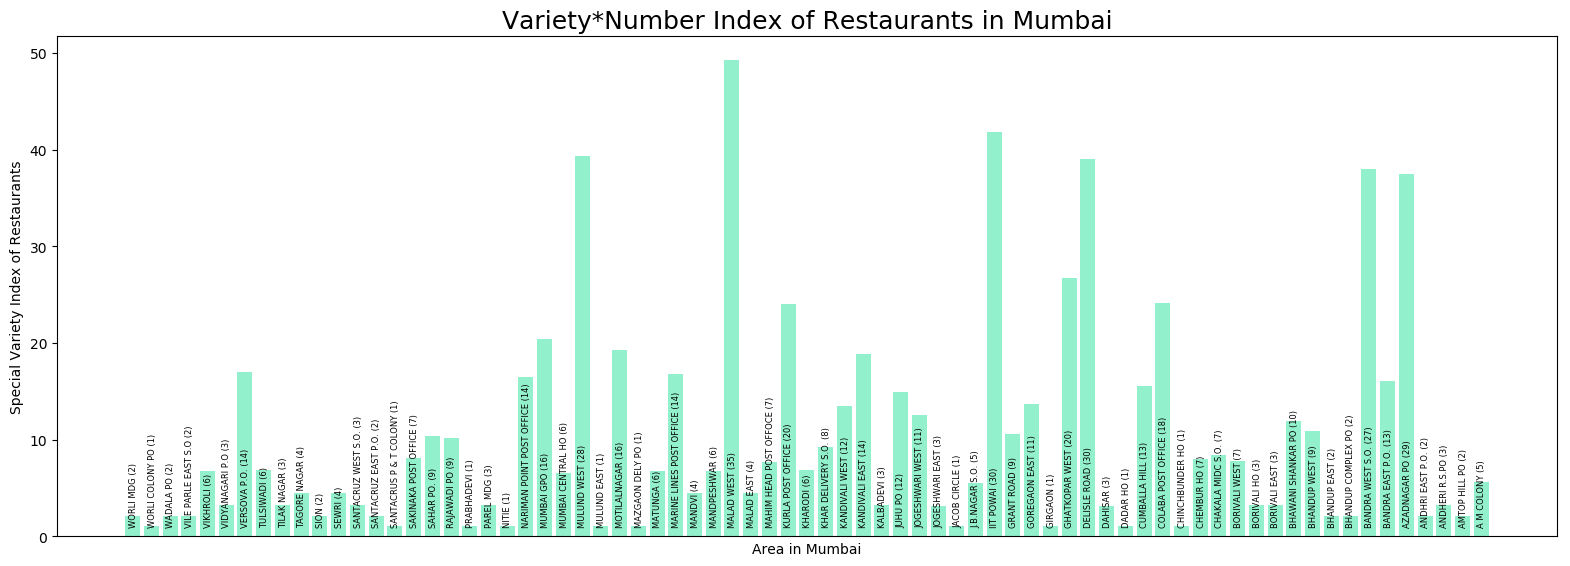

In [69]:
import math

RICH_MUM = AREA_TOT
RICH_MUM['Total'] = RICH_MUM['Total']
RICH_MUM = RICH_MUM.drop(['Latitude', 'Longitude'], axis=1)
RICH_MUM.sort_values(by= 'Area', ascending = False,inplace = True)
RICH_MUM.reset_index(drop=True,inplace = True)
#RICH_MUM = RICH_MUM.head(15)
RICH_MUM['Richness'] = 0

columns = RICH_MUM.columns
for index,row in RICH_MUM.iterrows():
    variety = 1
    r = 0
    for i in range(len(row)):
        if i < 2 or i == len(row)-1:
            continue
        value = row[i]
        if(value > 0):
            variety = variety + 0.05
        #r = math.log(value) * math.log(variety)
        r = r + variety * value
        #print(row['Area'], columns[i] ,row[i])
    RICH_MUM.iloc[index,len(row)-1] = r

fig = plt.figure(facecolor = 'w',figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(RICH_MUM['Area'],RICH_MUM['Richness'],color = '#93F0CC')
ax.set_xticks([])

for index,row in RICH_MUM.iterrows():
     ax.text(index - 0.2, 1 , row['Area']+' ('+ str(row['Total']) + ')', fontsize = 6, rotation= 90, color = 'black',verticalalignment='bottom')

ax.set_xlabel('Area in Mumbai')
ax.set_ylabel('Special Variety Index of Restaurants')

plt.title('Variety*Number Index of Restaurants in Mumbai',fontsize=18)

plt.show()

#### Top 15 Cusines in Top 15 Areas

### ANALYSIS

### RESULTS AND DISCUSSION

### CONCLUSION

['ALL_CAT_24_03_2020.csv']

In [73]:
# The code was removed by Watson Studio for sharing.